In [13]:
# import s3fs; import xarray as xr; import numpy as np
# import pandas as pd; import dask.array as da; import ocetrac
# import matplotlib.pyplot as plt; import cartopy.crs as ccrs
# import warnings; import expectexception
# warnings.filterwarnings('ignore')
# import netCDF4 as nc; import datetime as dt; import scipy
# import intake; import pprint
# # Allow multiple lines per cell to be displayed without print (default is just last line)
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# # Enable more explicit control of DataFrame display (e.g., to omit annoying line numbers)
# from IPython.display import HTML

In [1]:
# !pip install scikit-image==0.19.3
# del skimage
# import imp
import skimage
skimage.__version__

'0.19.3'

In [30]:
import importlib
import xarray as xr
import netCDF4 as nc
import h5netcdf
from skimage.measure import regionprops
import numpy as np
import matplotlib.pyplot as plt
# imp.reload(xr)

## ============================================================ below is something Valentina tried
# events = event_file
# for i in range(len(events.time)):
#     im = events.isel(time=0).SSTA.data
#     mask = xr.where(events.isel(time=i).SSTA>0, 1, 0).data
#     properties = regionprops(mask, im)
#     for prop in properties:
#         print(prop.centroid_weighted)

In [14]:
event_file =  xr.open_dataset('SSTA_and_events_0_3.nc')

In [44]:
from skimage.measure import label as label_np
from skimage.measure import regionprops

def _get_labels(binary_images):
    '''function used to label binary images at each time step using skimage.measure.label'''
    blobs_labels = label_np(binary_images, background=0)
    return blobs_labels

def _get_centroids(sub_labels):
    '''This function uses skimage.measure.regionprops to find the centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels.astype('int'))
    centroids = [(float(sub_labels.lat[round(p.centroid[0])].values),
                  float(sub_labels.lon[round(p.centroid[1])].values)) for p in props]
    for i in range(0,len(centroids)):
        if centroids[i][1] >= 359.75:
            centroids[i] = (centroids[i][0], list(centroids[i])[1] - 359.75)
    return centroids

def forOneMHW_labels_only(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    duration = calc_duration(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    forOneMHW_only_timesteps = for_one_mhw.labels[timesteps_to_choose_from,:,:]
    return forOneMHW_only_timesteps

def forOneMHW_SSTA_only(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    duration = calc_duration(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    forOneMHW_only_timesteps = for_one_mhw.SSTA[timesteps_to_choose_from,:,:]
    return forOneMHW_only_timesteps

def centroids_per_timestep(for_one_mhw_only, timestep):
    # Step 1. We start with one timestep and get all the sublabels
    timestep_of_interest = forOneMHW_onlylabels_timesteps[timestep,:,:]
    get_sub_lbs = timestep_of_interest
    sub_labels = _get_labels(get_sub_lbs)
    sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
    sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)

    # Step 2. We get all the labels on the edges
    edge_right_sub_labels_ = sub_labels[:,-1:]
    edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
    edge_left_sub_labels_ = sub_labels[:,:1]
    edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])

    edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
    nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
    nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

    centroid_list = []
    for i in nonedgecases:
        sub_labels_nonedgecases = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
        centroid_list.append(_get_centroids(sub_labels_nonedgecases))

    for i in edge_left_sub_labels:
        sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
        lon_edge = sub_labels_left[:,-1:].lon.item()
        sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
        for j in edge_right_sub_labels:
            sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
            east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
            append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
            append_east_binarized = xr.where(append_east > 0, 1, np.nan)
            sub_labels = _get_labels(append_east_binarized)
            sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
            sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
            centroid_list.append(_get_centroids(sub_labels))

    flat_centroid_list = list(set([item for sublist in centroid_list for item in sublist]))

    y_val = list(zip(*flat_centroid_list))[0]
    x_val = list(zip(*flat_centroid_list))[1]

    return flat_centroid_list

def _get_weighted_centroids(sub_labels, intensity, sub_labels_with_coords):
    '''This function uses skimage.measure.regionprops to find the weighted centroids of objects assigned 
    to each unique label'''
    props = regionprops(sub_labels, intensity, )
    w_centroids = [(float(sub_labels_with_coords.lat[round(p.centroid_weighted[0])].values),
                  float(sub_labels_with_coords.lon[round(p.centroid_weighted[1])].values)) for p in props]
    for i in range(0,len(w_centroids)):
        if w_centroids[i][1] >= 359.75:
            w_centroids[i] = (w_centroids[i][0], list(w_centroids[i])[1] - 359.75)
    return w_centroids

In [23]:
# sub_labels_nonedgecases_labels = xr.where(sub_labels_nonedgecases_labels == -9223372036854775808, 1, 0.)
# print(sub_labels_nonedgecases_labels.astype(int).data)
# sub_labels_nonedgecases = xr.where(sub_labels_nonedgecases_labels.isnull(), 0., sub_labels_nonedgecases)
# sub_labels_nonedgecases.plot.imshow(); plt.show()

In [24]:
# sub_labels_nonedgecases = sub_labels_nonedgecases.fillna(0)
# sub_labels_nonedgecases.plot.imshow(); plt.show()

In [25]:
# sub_labels_nonedgecases_labels = sub_labels_nonedgecases_labels.fillna(0)
# sub_labels_nonedgecases_labels.plot.imshow(); plt.show()

In [26]:
# props = regionprops(sub_labels_nonedgecases_labels.data.astype(int), sub_labels_nonedgecases.data)
# props[0].centroid_weighted

In [91]:
mhw_id = 35
timestep = 2

[(75.86387434554973, 258.75), (24.031413612565444, 180.0)]


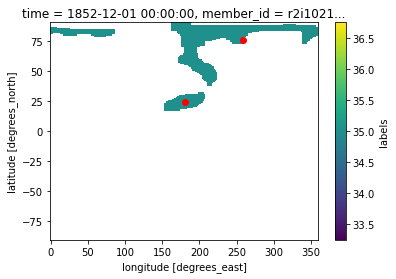

In [92]:
forOneMHW_onlylabels_timesteps = forOneMHW_labels_only(event_file, mhw_id)
# calculate centoids
flat_centroid_list = centroids_per_timestep(forOneMHW_onlylabels_timesteps, timestep)
print(flat_centroid_list)
y_val = list(zip(*flat_centroid_list))[0]; x_val = list(zip(*flat_centroid_list))[1]
forOneMHW_onlylabels_timesteps[timestep,:,:].plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()

In [34]:
forOneMHW_onlySSTA_timesteps = forOneMHW_SSTA_only(event_file, mhw_id)

In [35]:
# centroid_list = center_of_masses_per_timestep(forOneMHW_onlylabels_timesteps, forOneMHW_onlySSTA_timesteps, timestep)
# print(centroid_list)
# y_val = list(zip(*centroid_list))[0]; x_val = list(zip(*centroid_list))[1]
# forOneMHW_onlySSTA_timesteps[timestep,:,:].plot.imshow(vmin=0, vmax=8, cmap='Reds'); plt.scatter(x_val, y_val, c='red'); plt.show()

In [99]:
def make_array_approp(array1, array2):
    return xr.where(array1.isnull(), 0., array2)

In [154]:
timestep_of_interest = forOneMHW_onlylabels_timesteps[timestep,:,:]
SSTA_in_timestep = forOneMHW_onlySSTA_timesteps[timestep,:,:]
get_sub_lbs = timestep_of_interest
sub_labels = _get_labels(get_sub_lbs)
sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)

In [158]:
# label_in_timesteps = forOneMHW_onlylabels_timesteps[timestep,:,:]
# get_sub_lbs = timestep_of_interest
# SSTA_in_timestep = forOneMHW_onlySSTA_timesteps[timestep,:,:]
# sub_labels = _get_labels(label_in_timesteps)
# sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
# sub_labels = sub_labels.where(timestep>0, drop=False, other=np.nan)

edge_right_sub_labels = np.unique(np.unique(sub_labels[:,-1:])[~np.isnan(np.unique(sub_labels[:,-1:]))])
edge_left_sub_labels = np.unique(np.unique(sub_labels[:,:1])[~np.isnan(np.unique(sub_labels[:,:1]))])
edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

print(edge_right_sub_labels)
print(edge_left_sub_labels)

[3.]
[4.]


[[(24.973821989528794, 182.5)]]
4.0


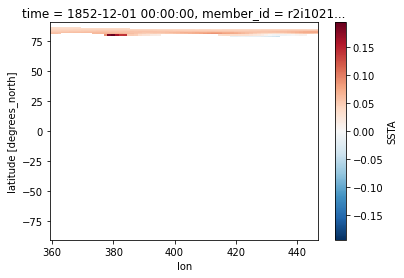

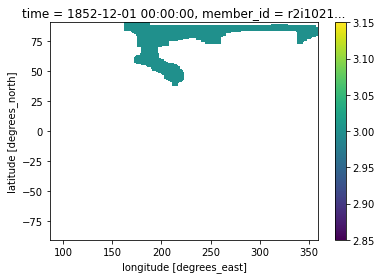

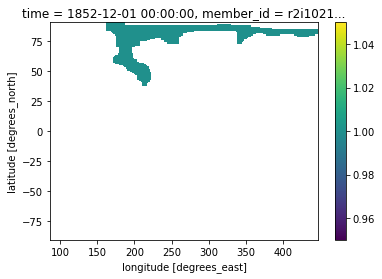

In [163]:
centroid_list = []
for i in nonedgecases:
    sub_labels_nonedgecases = xr.where(sub_labels==i, SSTA_in_timestep, np.nan)
    sub_labels_nonedgecases_labels = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
    
    sub_labels_nonedgecases = make_array_approp(sub_labels_nonedgecases_labels, sub_labels_nonedgecases).data
    sub_labels_nonedgecases_lbs_wcoord = make_array_approp(sub_labels_nonedgecases_labels, sub_labels_nonedgecases_labels)
    sub_labels_nonedgecases_labels = sub_labels_nonedgecases_labels.data.astype(int)
    centroid_list.append(_get_weighted_centroids(sub_labels_nonedgecases_labels,sub_labels_nonedgecases, sub_labels_nonedgecases_lbs_wcoord))
print(centroid_list)
for i in edge_left_sub_labels:
    sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
    lon_edge = sub_labels_left[:,-1:].lon.item()
    if lon_edge < 358.75:
        print(i)
        SSTA_left = SSTA_in_timestep.where((SSTA_in_timestep.lon <= lon_edge), drop=True)
        sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
        SSTA_left.coords['lon'] = (SSTA_left.coords['lon'] + 360) 
        SSTA_left.plot.imshow(); plt.show()
        for j in edge_right_sub_labels:
            sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
            east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
            east.plot.imshow(); plt.show()
            append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
            append_east = xr.where(append_east > 0, 1.0, np.nan)
            append_east.plot.imshow(); plt.show()
            SSTA_append_east = xr.where(append_east == 1.0, SST)

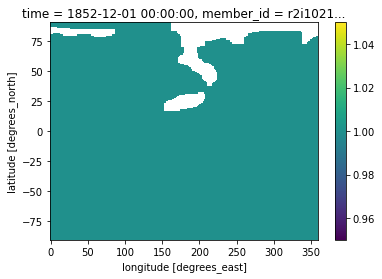

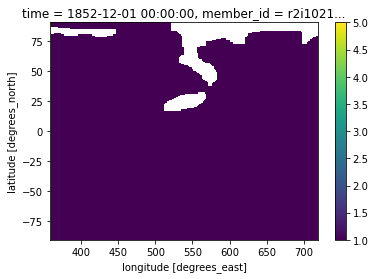

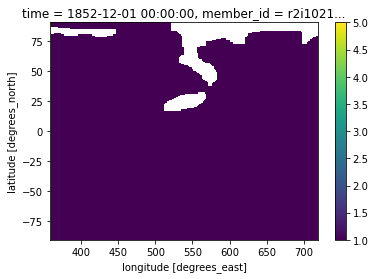

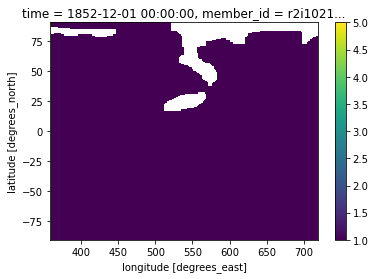

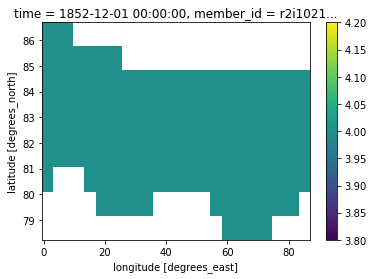

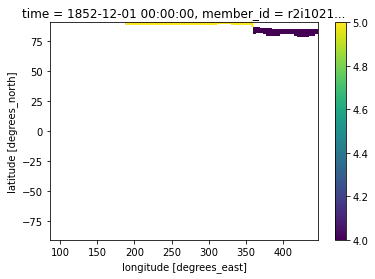

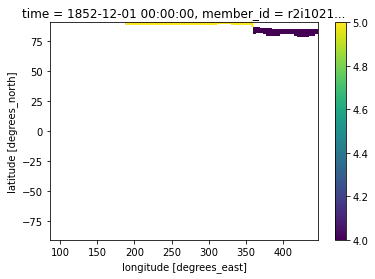

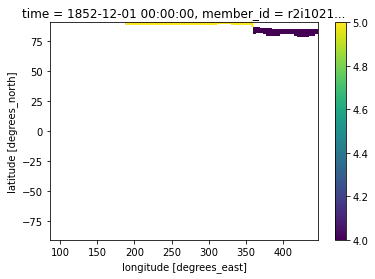

In [77]:
all_timesteps = forOneMHW_onlylabels_timesteps[:,:,:]
get_sub_lbs = all_timesteps[timestep,:,:]
SSTA_in_timestep = forOneMHW_onlySSTA_timesteps[timestep,:,:]
sub_labels = _get_labels(get_sub_lbs)
sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
sub_labels = sub_labels.where(timestep>0, drop=False, other=np.nan)

edge_right_sub_labels_ = sub_labels[:,-1:]
edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
edge_left_sub_labels_ = sub_labels[:,:1]
edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])

edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

centroid_list = []
for i in nonedgecases:
    sub_labels_nonedgecases = xr.where(sub_labels==i, SSTA_in_timestep, np.nan)
    sub_labels_nonedgecases_labels = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
    
    sub_labels_nonedgecases = xr.where(sub_labels_nonedgecases_labels.isnull(), 0., sub_labels_nonedgecases).data
    sub_labels_nonedgecases_labels_withlat = xr.where(sub_labels_nonedgecases_labels.isnull(), 0., sub_labels_nonedgecases_labels)
    sub_labels_nonedgecases_labels = sub_labels_nonedgecases_labels.data.astype(int)
    centroid_list.append(_get_weighted_centroids(sub_labels_nonedgecases_labels,sub_labels_nonedgecases, sub_labels_nonedgecases_labels_withlat))

for i in edge_left_sub_labels:
    sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
    lon_edge = sub_labels_left[:,-1:].lon.item()
    SSTA_left = SSTA_in_timestep.where((SSTA_in_timestep.lon <= lon_edge), drop=True)
    SSTA_in_timestep.where(mask_lon, drop=True)    
    sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
    SSTA_left.coords['lon'] = (SSTA_left.coords['lon'] + 360) 
    for j in edge_right_sub_labels:
        sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
        # east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
#             east.plot.imshow(); plt.show()
        append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
        append_east.plot.imshow(); plt.show()
          # append_east_binarized = xr.where(append_east > 0, 1, np.nan)

#             sub_labels_right = xr.where(sub_labels==j, SSTA_in_timestep, np.nan)
#             east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
#             append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), SSTA_left], dim="lon")
            
#     for i in edge_left_sub_labels:
#         sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
#         lon_edge = sub_labels_left[:,-1:].lon.item()
#         sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
#         for j in edge_right_sub_labels:
#             sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
#             east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
#             append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
#             append_east_binarized = xr.where(append_east > 0, 1, np.nan)
#             sub_labels = _get_labels(append_east_binarized)
#             sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
#             sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
#             centroid_list.append(_get_centroids(sub_labels))

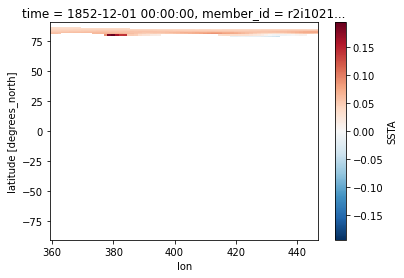

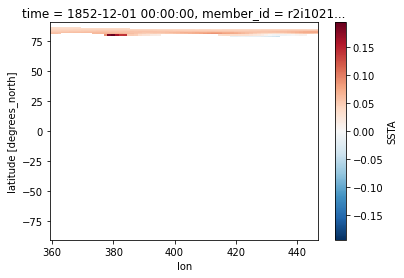

In [59]:
SSTA_left.plot.imshow(); plt.show()
SSTA_left.plot.imshow(); plt.show()

In [23]:
def center_of_masses_per_timestep(for_one_mhw_only_labels, for_one_mhw_only_SSTA, timestep):
    all_timesteps = forOneMHW_onlylabels_timesteps[:,:,:]
    get_sub_lbs = all_timesteps[timestep,:,:]
    SSTA_in_timestep = forOneMHW_onlySSTA_timesteps[timestep,:,:]
    sub_labels = _get_labels(get_sub_lbs)
    sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
    sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)

    edge_right_sub_labels_ = sub_labels[:,-1:]
    edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
    edge_left_sub_labels_ = sub_labels[:,:1]
    edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])

    edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
    nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
    nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

    centroid_list = []
    for i in nonedgecases:
        sub_labels_nonedgecases = xr.where(sub_labels==i, SSTA_in_timestep, np.nan)
        sub_labels_nonedgecases_labels = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
        x = sub_labels_nonedgecases.lon
        y = sub_labels_nonedgecases.lat

        (X,Y) = np.meshgrid(x,y)
        img = sub_labels_nonedgecases
        x_coord = (X*img).sum() / img.sum().astype("float")
        y_coord = (Y*img).sum() / img.sum().astype("float")
        coord = tuple([y_coord.item(), x_coord.item()])
        centroid_list.append(coord)

    for i in edge_left_sub_labels:
        sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
        lon_edge = sub_labels_left[:,-1:].lon.item()
        mask_lon = (SSTA_in_timestep.lon <= lon_edge)
        SSTA_left = SSTA_in_timestep.where(mask_lon, drop=True)
        SSTA_in_timestep.where(mask_lon, drop=True)    
        sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
        SSTA_left.coords['lon'] = (SSTA_left.coords['lon'] + 360) 
        for j in edge_right_sub_labels:
            sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
            east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
            append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
            append_east_binarized = xr.where(append_east > 0, 1, np.nan)

            sub_labels_right = xr.where(sub_labels==j, SSTA_in_timestep, np.nan)
            east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
            append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), SSTA_left], dim="lon")

            x = append_east.lon
            y = append_east.lat
            (X,Y) = np.meshgrid(x,y)
            img = append_east
            x_coord = (X*img).sum() / img.sum().astype("float")
            if x_coord > 360:
                x_coord = x_coord - 360
            y_coord = (Y*img).sum() / img.sum().astype("float")
            coord = tuple([y_coord.item(), x_coord.item()])
            centroid_list.append(coord)
    return centroid_list

In [18]:
all_timesteps = forOneMHW_onlylabels_timesteps[:,:,:]
timestep_of_interest = all_timesteps[timestep,:,:]
SSTA_in_timestep = forOneMHW_onlySSTA_timesteps[timestep,:,:]

get_sub_lbs = timestep_of_interest
sub_labels = _get_labels(get_sub_lbs)
sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)

edge_right_sub_labels_ = sub_labels[:,-1:]
edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
edge_left_sub_labels_ = sub_labels[:,:1]
edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])

edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

centroid_list = []
for i in nonedgecases:
    sub_labels_nonedgecases = xr.where(sub_labels==i, SSTA_in_timestep, np.nan)
    sub_labels_nonedgecases_labels = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
    x = sub_labels_nonedgecases.lon
    y = sub_labels_nonedgecases.lat

    (X,Y) = np.meshgrid(x,y)
    img = sub_labels_nonedgecases
    x_coord = (X*img).sum() / img.sum().astype("float")
    y_coord = (Y*img).sum() / img.sum().astype("float")
    coord = tuple([x_coord.item(), y_coord.item()])
    centroid_list.append(coord)

for i in edge_left_sub_labels:
    sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
    lon_edge = sub_labels_left[:,-1:].lon.item()
    mask_lon = (SSTA_in_timestep.lon <= lon_edge)
    SSTA_left = SSTA_in_timestep.where(mask_lon, drop=True)
    SSTA_in_timestep.where(mask_lon, drop=True)    
    sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
    SSTA_left.coords['lon'] = (SSTA_left.coords['lon'] + 360) 
    for j in edge_right_sub_labels:
        sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
        east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
        append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
        append_east_binarized = xr.where(append_east > 0, 1, np.nan)
            
        sub_labels_right = xr.where(sub_labels==j, SSTA_in_timestep, np.nan)
        east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
        append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), SSTA_left], dim="lon")
        
        x = append_east.lon
        y = append_east.lat
        (X,Y) = np.meshgrid(x,y)
        img = append_east
        x_coord = (X*img).sum() / img.sum().astype("float")
        if x_coord > 360:
            x_coord = x_coord - 360
        y_coord = (Y*img).sum() / img.sum().astype("float")
        coord = tuple([x_coord.item(), y_coord.item()])
        centroid_list.append(coord)
print(centroid_list)

<xarray.DataArray 'SSTA' (lat: 192, lon: 70)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 82.5 83.75 85.0 86.25
    time       object 1852-12-01 00:00:00
    member_id  <U11 'r2i1021p1f1'
    quantile   float64 0.9
    month      int64 12

(205.6678040825295, 60.35933978716709)
[(182.0432409364366, 24.919445951082455), (205.6678040825295, 60.35933978716709)]


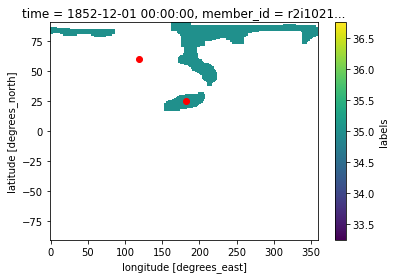

In [469]:
y_val = list(zip(*centroid_list))[1]
x_val = list(zip(*centroid_list))[0]

timestep_of_interest.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()

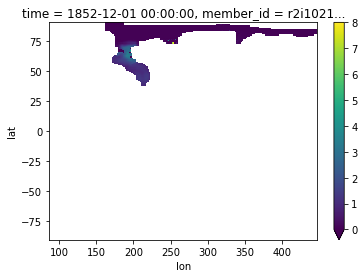

In [475]:
append_east.plot.imshow(vmin=0, vmax=8); plt.show()

In [466]:
(X,Y) = np.meshgrid(x,y)
img = append_east
x_coord = (X*img).sum() / img.sum().astype("float")
y_coord = (Y*img).sum() / img.sum().astype("float")
coord = tuple([x_coord.item(), y_coord.item()])

[(182.0432409364366, 24.919445951082455),
 (118.16780408252949, 60.35933978716709)]

In [368]:
append_east_binarized

<xarray.DataArray (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 87.5 88.75 90.0 91.25 ... 442.5 443.8 445.0 446.2
    time       object 1852-12-01 00:00:00
    member_id  <U11 'r2i1021p1f1'
    quantile   float64 0.9
    month      int64 12

In [389]:
append_east.lat[round(center_of_mass[1])].values

array(39.10994764)

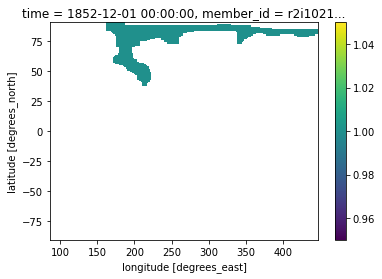

In [370]:
append_east_binarized.plot.imshow(); plt.show()

array([-9223372036854775808,                    1])

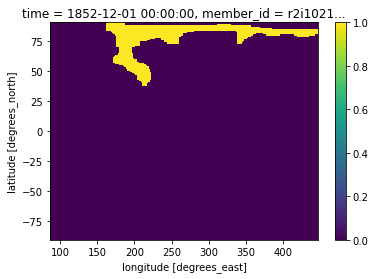

In [375]:
np.unique(append_east_binarized.astype('int'))
binary = xr.where(append_east_binarized==1.0, 1, 0)
binary.plot.imshow(); plt.show()

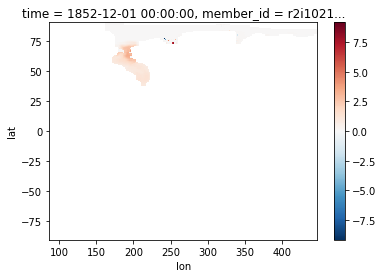

In [382]:
append_east = xr.where(append_east_binarized is not np.nan, append_east, 0)
append_east.plot.imshow(); plt.show()

In [398]:
# append_east.mean()
append_east = xr.where(append_east_binarized is not np.nan, append_east, 0)
append_east = (append_east*1000).astype(int)
append_east = xr.where(append_east == -9223372036854775808, append_east, 0)
print(np.unique(append_east))
ndimage.measurements.center_of_mass(append_east)

[0]


TypeError: 'numpy.float64' object is not iterable

In [387]:
# append_east
properties = regionprops(binary, append_east)
center_of_mass = properties[0].centroid
center_of_mass
# center_of_mass
# print(properties[0].weighted_centroid)
# weighted_center_of_mass = properties[0].weighted_centroid

(175.90976645435245, 136.56758669497523)

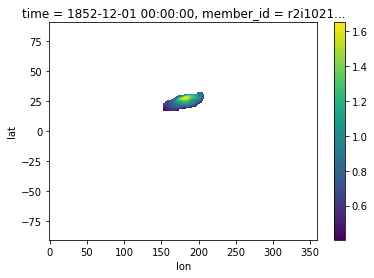

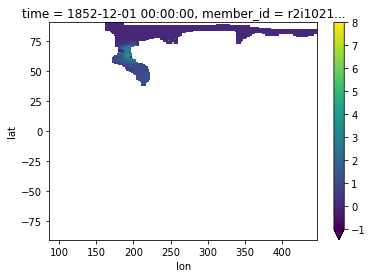

In [331]:
sub_labels_nonedgecases.plot.imshow(); plt.show()
append_east.plot.imshow(vmin=-1, vmax=8.); plt.show()

lon_edge:  86.25


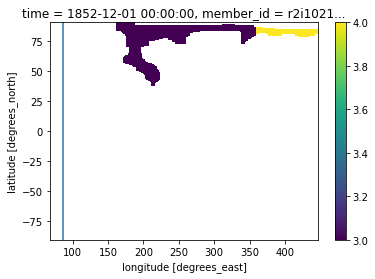

[(26.858638743455497, 185.0), (75.86387434554973, 258.75)]


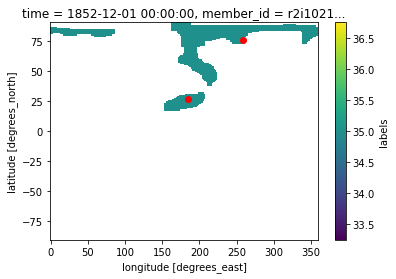

In [356]:
for i in edge_left_sub_labels:
    sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
    lon_edge = sub_labels_left[:,-1:].lon.item()
    print('lon_edge: ',lon_edge)
    sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
    for j in edge_right_sub_labels:
        sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
        east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
        append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
        append_east.plot.imshow(); plt.axvline(lon_edge); plt.show()
        append_east_binarized = xr.where(append_east > 0, 1, np.nan)
        sub_labels = _get_labels(append_east_binarized)
        sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
        sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
        centroid_list.append(_get_centroids(sub_labels))

flat_centroid_list = list(set([item for sublist in centroid_list for item in sublist]))
print(flat_centroid_list)

y_val = list(zip(*flat_centroid_list))[0]
x_val = list(zip(*flat_centroid_list))[1]

timestep_of_interest.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()

In [23]:
for_one_mhw = SSTA_and_events.where(SSTA_and_events.labels==mhw_id, drop=False)
mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
first_timestep = mhw_when[0][0]
timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)

all_timesteps = for_one_mhw.labels[timesteps_to_choose_from,:,:]

timestep = 2

In [ ]:
# on one marine heatwave
mhw_id = 35
event_file = SSTA_and_events

duration = calc_duration(event_file, mhw_id)

for_one_mhw = SSTA_and_events.where(SSTA_and_events.labels==mhw_id, drop=False)
mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
first_timestep = mhw_when[0][0]
timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
all_timesteps = for_one_mhw.labels[timesteps_to_choose_from,:,:]

[ 2.  3.  4. nan]


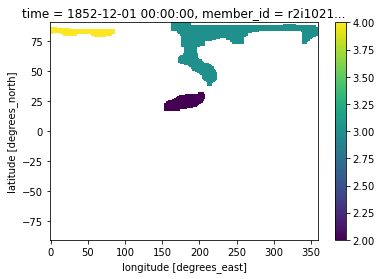

lon_edge:  86.25


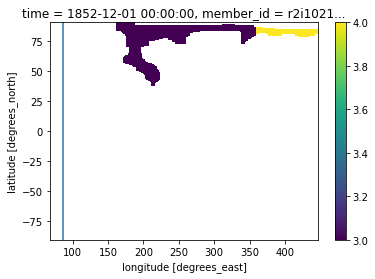

[(75.86387434554973, 258.75), (24.031413612565444, 180.0)]


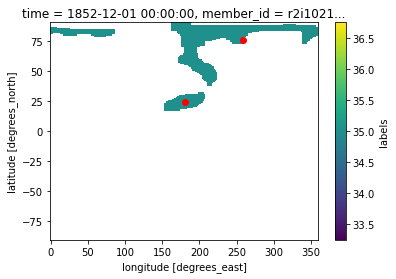

In [357]:
# Step 1. We start with one timestep and get all the sublabels
timestep_of_interest = all_timesteps[2,:,:]
get_sub_lbs = timestep_of_interest
sub_labels = _get_labels(get_sub_lbs)
sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)
print(np.unique(sub_labels))

sub_labels.plot.imshow(); plt.show()

# Step 2. We get all the labels on the edges
edge_right_sub_labels_ = sub_labels[:,-1:]
edge_right_sub_labels = np.unique(np.unique(edge_right_sub_labels_)[~np.isnan(np.unique(edge_right_sub_labels_))])
edge_left_sub_labels_ = sub_labels[:,:1]
edge_left_sub_labels = np.unique(np.unique(edge_left_sub_labels_)[~np.isnan(np.unique(edge_left_sub_labels_))])

edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

centroid_list = []
for i in nonedgecases:
    sub_labels_nonedgecases = sub_labels.where(sub_labels==i, drop=False, other=np.nan)
    centroid_list.append(_get_centroids(sub_labels_nonedgecases))

for i in edge_left_sub_labels:
    sub_labels_left = sub_labels.where(sub_labels==i, drop=True)
    lon_edge = sub_labels_left[:,-1:].lon.item()
    print('lon_edge: ',lon_edge)
    sub_labels_left.coords['lon'] = (sub_labels_left.coords['lon'] + 360) 
    for j in edge_right_sub_labels:
        sub_labels_right = sub_labels.where(sub_labels==j, drop=False, other=np.nan)
        east = sub_labels_right.where(sub_labels_right.lon > lon_edge, drop=True)
        append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_left], dim="lon")
        append_east.plot.imshow(); plt.axvline(lon_edge); plt.show()
        append_east_binarized = xr.where(append_east > 0, 1, np.nan)
        sub_labels = _get_labels(append_east_binarized)
        sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
        sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
        centroid_list.append(_get_centroids(sub_labels))

flat_centroid_list = list(set([item for sublist in centroid_list for item in sublist]))
print(flat_centroid_list)

y_val = list(zip(*flat_centroid_list))[0]
x_val = list(zip(*flat_centroid_list))[1]

timestep_of_interest.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()

[ 2.  3.  4. nan]


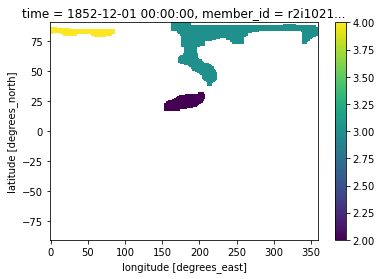

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [155]:
# Step 1. We start with one timestep and get all the sublabels
timestep_of_interest = all_timesteps[2,:,:]
get_sub_lbs = timestep_of_interest
sub_labels = _get_labels(get_sub_lbs)
sub_labels = xr.DataArray(sub_labels, dims=get_sub_lbs.dims, coords=get_sub_lbs.coords)
sub_labels = sub_labels.where(timestep_of_interest>0, drop=False, other=np.nan)
print(np.unique(sub_labels))

sub_labels.plot.imshow(); plt.show()

# Step 2. We get all the labels on the edges
edge_right_sub_labels_ = sub_labels[:,-1:]
edge_right_sub_labels = np.unique(edge_right_sub_labels_)
edge_left_sub_labels_ = sub_labels[:,:1]
edge_left_sub_labels = np.unique(edge_left_sub_labels_)

edge_labels = np.unique(np.concatenate((edge_right_sub_labels, edge_left_sub_labels)))
nonedgecases = np.setdiff1d(np.unique(sub_labels), edge_labels)
nonedgecases = np.unique(nonedgecases[~np.isnan(nonedgecases)])

# sub_labels_nonedgecases.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()

# checking_if_we_have_multiple = np.nan_to_num(edge_right_sub_labels_.values) + np.nan_to_num(edge_left_sub_labels_.values)
# for i in edge_right_sub_labels_:
    
# sub_labels_4 = sub_labels.where(sub_labels==4, drop=True)
# lon_edge = sub_labels_4[:,-1:].lon.item()

# sub_labels_4.coords['lon'] = (sub_labels_4.coords['lon'] + 360) 

# sub_labels_3 = sub_labels.where(sub_labels==3, drop=False, other=np.nan)

# east = sub_labels_3.where(sub_labels_3.lon > lon_edge, drop=True)
# east.plot.imshow(); plt.show()

# append_east = xr.concat([east.where(east.lon >= lon_edge, drop=True), sub_labels_4], dim="lon")
# append_east.plot.imshow(); plt.show()

# # make everything into one label
# # append_east_binarized = append_east.where((np.isnan(append_east)==True),1)
# append_east_binarized = xr.where(append_east > 0, 1, np.nan)
# np.unique(append_east_binarized)
# append_east_binarized.plot.imshow(); plt.show()

# # get sublabels
# sub_labels = _get_labels(append_east_binarized)
# sub_labels = xr.DataArray(sub_labels, dims=append_east_binarized.dims, coords=append_east_binarized.coords)
# sub_labels = sub_labels.where(append_east_binarized>0, drop=False, other=np.nan)
# print(np.unique(sub_labels))

# centroid_wrap = _get_centroids(sub_labels)
# print(centroid_wrap)

# y_val = list(zip(*centroid_wrap))[0]
# x_val = list(zip(*centroid_wrap))[1]

# sub_labels.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()

In [45]:
lx = all_timesteps.isel(time=timestep)
east = lx.where(lx.lon < 180, drop=True)
east['lon'] = np.arange(360.25, 540.25, 1.25) # this value is related to your grid resolution
append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")

append_east.plot.imshow(figsize=(10,5))
all_timesteps[timestep,:,:].plot.imshow(figsize=(10,5))

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5],
       [1, 1, 1, ..., 5, 5, 5]])

In [14]:
all_timesteps = all_timesteps.pad(lon=(144, 144), )

ValueError: Axis limits cannot be NaN or Inf

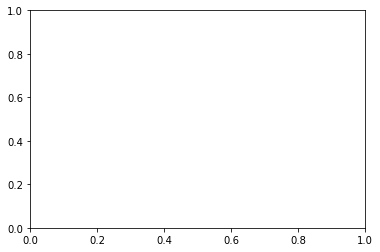

In [16]:
all_timesteps[timestep,:,:].plot.imshow()

In [11]:
all_timesteps

<xarray.DataArray 'labels' (time: 10, lat: 192, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [35., 35., 35., ..., 35., 35., 35.],
        [35., 35., 35., ..., 35., 35., 35.],
        [35., 35., 35., ..., 35., 35., 35.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [35., 35., 35., ..., 35., 35., 35.],
        [35., 35., 35., ..., 35., 35., 35.],
        [35., 35., 35., ..., 35., 35., 35.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1852-10-01 00:00:00 ... 1853-07-01 00:00:00
    member_id  <U11 'r2i1021p1f1'
    quantile   float64 0.9
    month      (time) int64 10 11 12 1 2 3 4 5 6 7
Attributes:
    inital objects identified:  21386
    final objects tracked:      1203
    radius:                     3
    size quantile threshold:    0.75
    min area:                   349.0
    percent area reject:        0.27032961568982916
    percent area accept:        0.7296703843101708

In [18]:
one_ = all_timesteps[timestep,:,:].values
one_
# plt.pcolor(one_); plt.axvline(288/2); plt.xticks([0,288]);plt.show()

# x = np.pad(one_, pad_width=[(0,0),(144,144)], mode='constant', constant_values=100)
# plt.pcolor(x); plt.axvline(288); plt.xticks([0,288]);plt.show()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [68]:
y_val = list(zip(*centroid_wrap))[0]
x_val = list(zip(*centroid_wrap))[1]

print(x)
print(y)

(4.25, 168.0, 192.5, 265.0, 176.75, 173.0)
(-4.240837696335079, 22.14659685863874, 25.916230366492147, 75.86387434554973, 59.84293193717277, 83.40314136125654)


In [46]:
timestep = 2
sub_labels = _get_labels(all_timesteps[timestep,:,:])
sub_labels = xr.DataArray(sub_labels, dims=append_east.dims, coords=append_east.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan)

centroid_wrap = _get_centroids(sub_labels)
print(centroid_wrap)

y_val = list(zip(*centroid_wrap))[0]
x_val = list(zip(*centroid_wrap))[1]

y_val_orig = y_val
x_val_orig = [x - 180 for x in x_val]
print(y_val_orig)
print(x_val_orig)
print(len(x_val_orig))
sub_labels.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()
all_timesteps[timestep,:,:].plot.imshow(); plt.scatter(x_val_orig, y_val_orig, c='red'); plt.show()

NameError: name 'append_east' is not defined

[1 2 3 4 5 6]
[(-4.240837696335079, 364.0), (22.14659685863874, 527.75), (25.916230366492147, 192.5), (75.86387434554973, 265.0), (59.84293193717277, 536.5), (83.40314136125654, 532.75)]
6


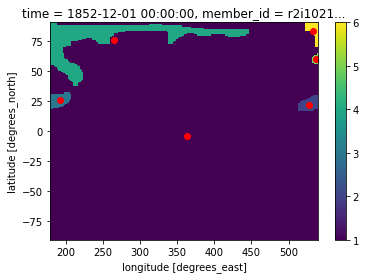

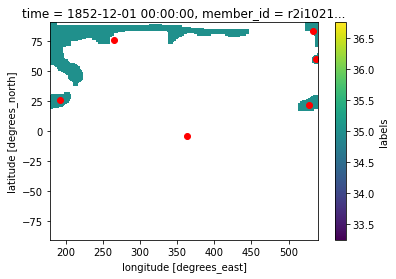

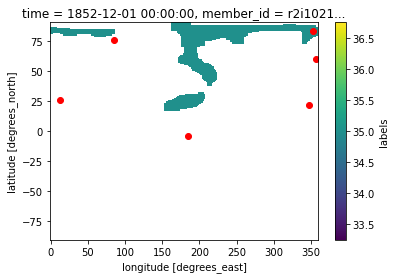

In [49]:
sub_labels = _get_labels(append_east)
print(np.unique(sub_labels))
sub_labels = xr.DataArray(sub_labels, dims=append_east.dims, coords=append_east.coords)
sub_labels = sub_labels.where(sub_labels>0, drop=False, other=np.nan)
centroid_wrap = _get_centroids(sub_labels)
print(centroid_wrap)

y_val = list(zip(*centroid_wrap))[0]
x_val = list(zip(*centroid_wrap))[1]

y_val_orig = y_val
x_val_orig = [x - 180 for x in x_val]
print(len(y_val))

sub_labels.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()
append_east.plot.imshow(); plt.scatter(x_val, y_val, c='red'); plt.show()
all_timesteps[timestep,:,:].plot.imshow(); plt.scatter(x_val_orig, y_val, c='red'); plt.show()

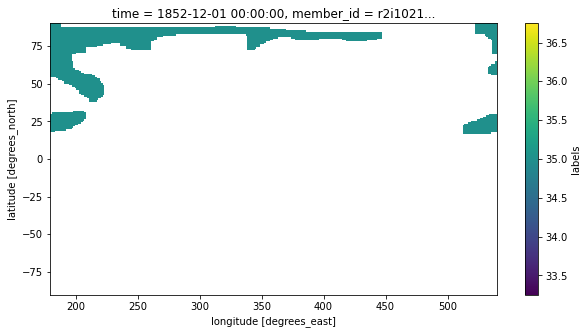

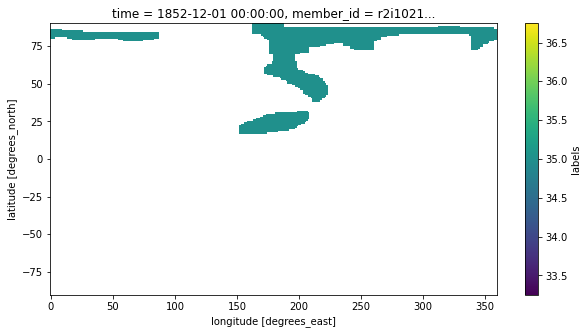

In [48]:
for_one_mhw = SSTA_and_events.where(SSTA_and_events.labels==mhw_id, drop=False)
mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
first_timestep = mhw_when[0][0]
timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)

all_timesteps = for_one_mhw.labels[timesteps_to_choose_from,:,:]

timestep = 2

lx = all_timesteps.isel(time=timestep)
east = lx.where(lx.lon < 180, drop=True)
east['lon'] = np.arange(360.25, 540.25, 1.25) # this value is related to your grid resolution
append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")

append_east.plot.imshow(figsize=(10,5))
all_timesteps[timestep,:,:].plot.imshow(figsize=(10,5))



(192, 288)


([<matplotlib.axis.XTick at 0x2ae0fad06700>,
 [Text(0, 0, ''), Text(0, 0, '')])

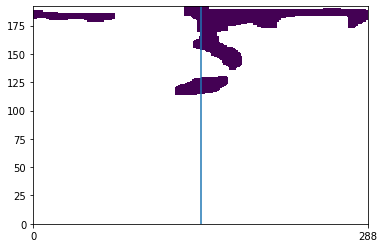

([<matplotlib.axis.XTick at 0x2ae0faf0b040>,
 [Text(0, 0, ''), Text(0, 0, '')])

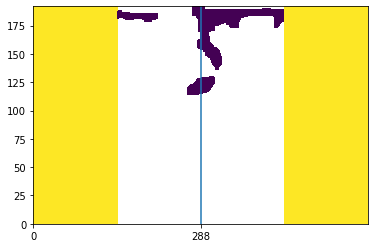

In [159]:
one_ = all_timesteps[timestep,:,:].values
print(one_.shape)
plt.pcolor(one_); plt.axvline(288/2); plt.xticks([0,288]);plt.show()
x = np.pad(one_, pad_width=[(0,0),(144,144)], mode='constant', constant_values=100)
plt.pcolor(x); plt.axvline(288); plt.xticks([0,288]);plt.show()

In [160]:
x[:,432:512] = x[:,144:224]
x[:,144:224] = x[:,144:224]

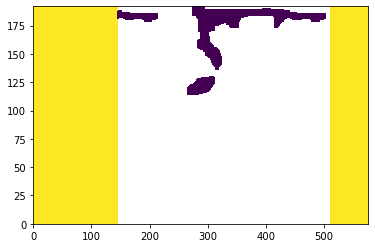

In [161]:
plt.pcolor(x)
# plt.axvline(435)
# plt.axvline(145)

In [156]:
lx = all_timesteps.isel(time=timestep)
east = lx.where(lx.lon < 180, drop=True)
east['lon'] = np.arange(360.25, 540.25, 1.25) # this value is related to your grid resolution
append_east = xr.concat([lx.where(lx.lon >= 180, drop=True), east], dim="lon")

In [32]:
# functions
def number_of_mhws(event_file):
    return len(np.unique(event_file.labels)) - 1

def calc_duration(event_file, mhw_id):
    return len(event_file.where(event_file.labels==mhw_id, drop=True).time)

def calc_cumulativeintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    cumulative_intensity = np.nansum(for_one_mhw.SSTA)
    cumulative_intensity_monthly = for_one_mhw.SSTA.sum(axis=(1,2)).values
    return cumulative_intensity, cumulative_intensity_monthly

def calc_meanintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    mean_intensity = np.nanmean(for_one_mhw.SSTA)
    mean_intensity_monthly = for_one_mhw.SSTA.mean(axis=(1,2)).values
    return mean_intensity, mean_intensity_monthly

def calc_maximumintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    max_intensity = np.nanmax(for_one_mhw.SSTA)
    max_intensity_monthly = for_one_mhw.SSTA.max(axis=(1,2)).values
    return max_intensity, max_intensity_monthly

def calc_stdintensity(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    std_intensity = np.nanstd(for_one_mhw.SSTA)
    std_intensity_monthly = for_one_mhw.SSTA.std(axis=(1,2)).values
    return std_intensity, std_intensity_monthly

def calc_spatialextent(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    spatial_extents = []
    coords_full = []
    for i in range(len(for_one_mhw.time)):
        for_onetimestep_stacked = for_one_mhw.labels[i,:,:].stack(zipcoords=['lat','lon'])
        intermed = for_onetimestep_stacked[for_onetimestep_stacked.notnull()].zipcoords.values
        lats = [x[0] for x in intermed]; lons = [x[1] for x in intermed]
        coords = list(zip(lats, lons))
        coords_full.append(coords)
        y,x=zip(*coords)
        dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]; dlat = (110.574 *1) * np.ones(len(dlon))
        area = np.sum(dlon*dlat)
        spatial_extents.append(area)
    max_spatial_extent = np.max(spatial_extents)
    max_spatial_extent_time = np.argmax(spatial_extents)
    mean_spatial_extent = np.mean(spatial_extents)
    cumulative_spatial_extent = np.sum(spatial_extents)
    return coords_full, spatial_extents, max_spatial_extent, max_spatial_extent_time, mean_spatial_extent, cumulative_spatial_extent

def initialization(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    mhw_when = np.argwhere(for_one_mhw.labels.max(axis=(1,2)).values > 0.)
    first_timestep = mhw_when[0][0]
    bymonth = np.resize(np.arange(1,13),12*166)[1:-11]
    month = bymonth[first_timestep]
    return first_timestep, for_one_mhw.SSTA[first_timestep,:,:].values, month

from skimage.measure import find_contours
from haversine import haversine, Unit
from scipy.interpolate import interp1d

def calc_perimeter(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    first_timestep, first_array, month = initialization(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)

    convert_long_range = interp1d([0,360],[-180,180])
    perimeter_ls = []
    for i in timesteps_to_choose_from:
        bw = for_one_mhw.labels[i,:,:].values > 0
        contours = find_contours(bw)
        distance_ls = []
        for contour_num in range(len(contours)):
            latitudes = for_one_mhw.lat.values[contours[contour_num][:,0].astype(int)]
            longitudes = for_one_mhw.lon.values[contours[contour_num][:,1].astype(int)]    
            coords = list(zip(latitudes, convert_long_range(longitudes)))

            for i in range(len(coords)-1):
                distance = haversine(coords[i], coords[i+1],Unit.KILOMETERS)
                distance_ls.append(distance)
            distance_ls.append(haversine(coords[len(coords)-1], coords[0],Unit.KILOMETERS))
        perimeter = np.sum(distance_ls)
        perimeter_ls.append(perimeter)
    return perimeter_ls  

def calc_percperimetervsarea(spatial_extents, perimeters):
    return (np.asarray(perimeters)/np.asarray(spatial_extents))*100

def convert_from_timeres_to_months(time_step):
    bymonth = np.resize(np.arange(1,13),12*166)[1:-11]
    month = bymonth[first_timestep]
    return month

def calc_compltodeform(coords_full, spatial_extents):
    perc_sharedarea_ls = []
    for i in range(len(coords_full)-1):
        a_set = set(coords_full[i])
        b_set = set(coords_full[i+1])
        if a_set & b_set:
            coords = a_set & b_set
            y,x=zip(*coords)
            dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]; dlat = (110.574 *1) * np.ones(len(dlon))
            sharedarea = np.sum(dlon*dlat)
            perc_sharedarea_ls.append((sharedarea/ (spatial_extents[i] + spatial_extents[i+1]))*100)
        else:
            sharedareaarea = 0
            perc_sharedarea_ls.append((sharedarea/ (spatial_extents[i] + spatial_extents[i+1]))*100)
    return perc_sharedarea_ls

def calc_deform(perc_sharedarea_ls):
    return np.asarray(100 - np.asarray(perc_sharedarea_ls))

def calc_whenlargesmall(spatial_extents):
    when_large = (np.argmax(spatial_extents) / len(spatial_extents))*100
    when_small = (np.argmin(spatial_extents) / len(spatial_extents))*100
    return when_large, when_small

def cross_correlation_spat(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=False)
    first_timestep, first_array, month = initialization(event_file, mhw_id)
    timesteps_to_choose_from = np.arange(first_timestep, first_timestep+duration)
    cc_image_array = np.zeros((len(timesteps_to_choose_from), 192,288))    

    for i in range(len(timesteps_to_choose_from[:-1])):
        image = for_one_mhw.SSTA[timesteps_to_choose_from[i],:,:].values
        image = np.nan_to_num(image)
        offset_image = for_one_mhw.SSTA[timesteps_to_choose_from[i+1],:,:].values
        offset_image = np.nan_to_num(offset_image)
        image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
        cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
        cc_image_array[i,:,:] = np.real(cc_image)
    return cc_image_array

from skimage.morphology import convex_hull_image
from skimage import img_as_float

def perc_imoverchull(event_file, mhw_id):
    for_one_mhw = event_file.where(event_file.labels==mhw_id, drop=True)
    perc_imoverchull_ls = []
    for i in range(len(for_one_mhw.time)):
        image = for_one_mhw.labels[i].values
        image = [image == mhw_id][0]
        chull = convex_hull_image(image)
        chull_asflt = img_as_float(chull.copy())
        image_asflt = img_as_float(image.copy())
        perc_imoverchull = np.sum(image_asflt)/np.sum(chull_asflt)*100
        perc_imoverchull_ls.append(perc_imoverchull)
    return perc_imoverchull_ls